In [1]:
import pandas as pd # data frames
import numpy as np
import re # regular expressions
import seaborn as sns # plotting
from scipy.stats import uniform, iqr # training/test split
import scipy.stats as sp # summary stats
import statsmodels.api as sm # stats models (including regression)
import statsmodels.formula.api as smf # R-like model specification - ordinary least squares
import matplotlib.pyplot as plt # 2D plotting
from sklearn import preprocessing # normalize the data
from fuzzymatcher import link_table, fuzzy_left_join # merge data frames with similar column entries


In [2]:
# coaches data
coachesDF = pd.read_csv('Coaches9.csv')
print("There are {} rows and {} variables in Coaches data.".format(coachesDF.shape[0], coachesDF.shape[1]))

# graduation data
gradDF = pd.read_csv('graddata.tsv', sep = '\t')
print("There are {} rows and {} variables in Graduation data.".format(gradDF.shape[0], gradDF.shape[1]))

# stadium data
stadiumDF = pd.read_csv('stadiums.csv')
print("There are {} rows and {} variables in Stadium data.".format(stadiumDF.shape[0], stadiumDF.shape[1]))

# win-loss-rank data
winlossDF = pd.read_csv('winloss19.csv')
print("There are {} rows and {} variables in Win Loss data.".format(winlossDF.shape[0], winlossDF.shape[1]))

There are 129 rows and 9 variables in Coaches data.
There are 345 rows and 226 variables in Graduation data.
There are 258 rows and 6 variables in Stadium data.
There are 130 rows and 8 variables in Win Loss data.


## Clean the data

In [3]:
# drop NaN from stadiumDF
stadiumDF.dropna(inplace = True)

# change -- to 0 
# strip $ and , from values 
# strip [<digit(s)>] from values
# convert to float
def cleandata(entry):
    entry = re.sub('--', '0', str(entry))
    entry = re.sub('\$|,', '', str(entry))
    entry = re.sub(r'\[\w+\s?\w*\]', '', str(entry))
    return float(entry)

coachesDF['TotalPay'] = [cleandata(entry) for entry in coachesDF['TotalPay']]
coachesDF['Bonus'] = [cleandata(entry) for entry in coachesDF['Bonus']]
coachesDF['Buyout'] = [cleandata(entry) for entry in coachesDF['Buyout']]
coachesDF['BonusPaid'] = [cleandata(entry) for entry in coachesDF['BonusPaid']]
stadiumDF['Capacity'] = [cleandata(entry) for entry in stadiumDF['Capacity']]

In [4]:
# add the salary variable
salary = []
for i in range(len(coachesDF)):
    # salary = total pay - bonus - in millions
    sal = (coachesDF['TotalPay'][i] - coachesDF['BonusPaid'][i])
    # if bonus is greater than salary, salary = total pay 
    if sal < 0:
        sal = coachesDF['TotalPay'][i]
    salary.append(sal)
#print(salary)
coachesDF['Salary'] = salary

In [5]:
# add a BonusRatio variable - ratio of bonuspaid/bonus
bonusratio = []
for row, cols in coachesDF[['Bonus', 'BonusPaid']].iterrows():
    # if Bonus = 0, BonusRatio = 0
    if (cols[0] == 0) & (cols[1] == 0):
        bonusratio.append(0)
    # if Bonus = 0 and BonusPaid is not, coach earned an unscheduled bonus
    elif (cols[0] == 0) & (cols[1] != 0):
        bonusratio.append(100)
    # otherwise BonusRatio = BonusPaid/Bonus    
    else:
        bonusrat = cols[1]/cols[0]
        bonusratio.append(bonusrat)
coachesDF['BonusRatio'] = bonusratio
    

In [6]:
# reindex the data frame
coachesDF = coachesDF.reindex()

# find rows where TotalPay = 0 and remove
zeropay = coachesDF.loc[coachesDF['TotalPay'] == 0]
print("The schools to drop are:\n", zeropay['School'])
print("There are {} schools without salary information.".format(len(zeropay)))

# remove these schools
coachesDF = coachesDF.loc[coachesDF['TotalPay'] != 0]
print("There are now {} rows and {} variables.".format(coachesDF.shape[0], coachesDF.shape[1]))

The schools to drop are:
 12                Baylor
16         Brigham Young
91                  Rice
99    Southern Methodist
Name: School, dtype: object
There are 4 schools without salary information.
There are now 125 rows and 11 variables.


## Merge the data frames

Coach and stadium by "School"
Coach/Stadium and winloss by "School"
Coach/Stadium/WinLoss and Graduation by "SCL_UNITID"

In [7]:
# left merge coaches and stadium
coach_stad_df = coachesDF.merge(stadiumDF, how = 'left', left_on = 'School', right_on = 'Team')

# left merge with WinLoss
coach_stad_wl_df = coach_stad_df.merge(winlossDF, how = 'left', left_on = 'School', right_on = 'School')

# left merge with Graduation
labdf = fuzzy_left_join(coach_stad_wl_df, gradDF, left_on = 'School', right_on = 'SCL_NAME')
#labdf = coach_stad_wl_df.merge(gradDF, how = 'left', left_on = 'SchoolID', right_on = 'SCL_UNITID')

### Define Terms

SA = student athletes 
SB = student body (SA included) 
GSR = graduation success rate for SA 
FED = graduation success rate for SB  
RATE = relative frequency
SCL_SUBDIVISION = D1 football: 1 = FBS 2 = FCS 3 = I-AAA 
SCL_HBCU = Historically Black College or University
SCL_PRIVATE = Private or Public University


In [8]:
# keep only relevant variables - those that relate to stadium size, location
# graduation rates (student body and athletes), school info (conference, name)
# salary information

# salary/coach variables
coach_col_to_keep = ['School', 'Conference_x', 'Coach', 'TotalPay', 'Bonus', 'Salary', 'Buyout', 'BonusRatio']
# stadium variables
stadium_col_to_keep = ['Capacity']
# graduation variables
grad_col_to_keep = ['SCL_NAME', 'SCL_HBCU', 'SCL_PRIVATE', 'SCL_SUBDIVISION',
                    'FED_RATE_2008_SA', 'FED_RATE_2008_SB', 'GSR_2008_SA', 
                    'FED_RATE_SA', 'GSR_SA', 'FED_RATE_SB']
                    

# win loss variables
wl_col_to_keep = ['W', 'L', 'Pct']

# all columns to keep
all_col_to_keep = coach_col_to_keep + stadium_col_to_keep + grad_col_to_keep + wl_col_to_keep
labdf = labdf[all_col_to_keep]
labdf = labdf.rename(columns = {'Conference_x': 'Conference'})
print('\nThe data has {} variables and {} schools.'.format(labdf.shape[1], labdf.shape[0]))


The data has 22 variables and 125 schools.


### Impute missing values 

In [9]:
# where are the missing values?
labdf.isna().sum()

School               0
Conference           0
Coach                0
TotalPay             0
Bonus                0
Salary               0
Buyout               0
BonusRatio           0
Capacity            17
SCL_NAME             4
SCL_HBCU             4
SCL_PRIVATE          4
SCL_SUBDIVISION      4
FED_RATE_2008_SA     4
FED_RATE_2008_SB     4
GSR_2008_SA          4
FED_RATE_SA          4
GSR_SA               4
FED_RATE_SB          4
W                   12
L                   12
Pct                 12
dtype: int64

In [10]:
# replace NaN with 0 to impute
labdf['Capacity'].fillna(0, inplace = True)

In [11]:
# median stadium capacity by conference
conf_capacity = labdf[['Conference', 'Capacity']].groupby('Conference').median()
conf_capacity

,Capacity
Conference,
AAC,32000.0
ACC,53000.0
Big 12,60218.0
Big Ten,65627.5
C-USA,22113.0
Ind.,30343.0
MAC,25624.0
Mt. West,33421.5
Pac-12,55014.5


In [12]:
# impute empty Buyout values with median buyout by conference    
for row, cols in labdf[['Capacity', 'Conference']].iterrows():
    # if capacity = 0 and conference = AAC 
    if (cols[0] == 0) & (cols[1] == 'AAC'):
        # impute median
        labdf['Capacity'][row] = conf_capacity.loc['AAC'][0]
    elif (cols[0] == 0) & (cols[1] == 'ACC'):
        labdf['Capacity'][row] = conf_capacity.loc['ACC'][0]
    elif (cols[0] == 0) & (cols[1] == 'Big 12'):
        labdf['Capacity'][row] = conf_capacity.loc['Big 12'][0]
    elif (cols[0] == 0) & (cols[1] == 'Big Ten'):
        labdf['Capacity'][row] = conf_capacity.loc['Big Ten'][0]
    elif (cols[0] == 0) & (cols[1] == 'C-USA'):
        labdf['Capacity'][row] = conf_capacity.loc['C-USA'][0]
    elif (cols[0] == 0) & (cols[1] == 'Ind.'):
        labdf['Capacity'][row] = conf_capacity.loc['Ind.'][0]
    elif (cols[0] == 0) & (cols[1] == 'MAC'):
        labdf['Capacity'][row] = conf_capacity.loc['MAC'][0]
    elif (cols[0] == 0) & (cols[1] == 'Mt. West'):
        labdf['Capacity'][row] = conf_capacity.loc['Mt. West'][0]
    elif (cols[0] == 0) & (cols[1] == 'Pac-12'):
        labdf['Capacity'][row] = conf_capacity.loc['Pac-12'][0]
    elif (cols[0] == 0) & (cols[1] == 'SEC'):
        labdf['Capacity'][row] = conf_capacity.loc['SEC'][0]
    elif (cols[0] == 0) & (cols[1] == 'Sun Belt'):
        labdf['Capacity'][row] = conf_capacity.loc['Sun Belt'][0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A

In [15]:
# Which schools have no win loss information?
labdf.loc[labdf['W'].isnull()]

,School,Conference,Coach,TotalPay,Bonus,Salary,Buyout,BonusRatio,Capacity,SCL_NAME,...,SCL_SUBDIVISION,FED_RATE_2008_SA,FED_RATE_2008_SB,GSR_2008_SA,FED_RATE_SA,GSR_SA,FED_RATE_SB,W,L,Pct
7,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0,734529.0,3847500.0,0.174180,22113.0,University of Alabama at Birmingham,...,1.0,76.0,55.0,84.0,62.0,75.0,50.0,NaN,NaN,NaN
24,Bowling Green,MAC,Mike Jinks,437228.0,245000.0,355978.0,874456.0,0.331633,24000.0,Bowling Green State University-Main Campus,...,1.0,70.0,55.0,90.0,66.0,85.0,56.0,NaN,NaN,NaN
41,Central Florida,AAC,Josh Heupel,1700000.0,250000.0,1700000.0,3587500.0,0.000000,32000.0,University of Central Florida,...,1.0,54.0,70.0,88.0,55.0,93.0,66.0,NaN,NaN,NaN
109,Louisiana-Lafayette,Sun Belt,Billy Napier,850000.0,435000.0,850000.0,2671875.0,0.000000,30000.0,University of Louisiana at Lafayette,...,1.0,64.0,48.0,83.0,65.0,80.0,45.0,NaN,NaN,NaN
120,Miami (Fla.),ACC,Mark Richt,4058061.0,0.0,4058061.0,0.0,0.000000,53000.0,University of Miami,...,1.0,57.0,81.0,84.0,60.0,89.0,80.0,NaN,NaN,NaN
122,Miami (Ohio),MAC,Chuck Martin,524826.0,582110.0,512157.0,522300.0,0.021764,25624.0,University of Miami,...,1.0,57.0,81.0,84.0,60.0,89.0,80.0,NaN,NaN,NaN
132,Middle Tennessee,C-USA,Rick Stockstill,803004.0,126142.0,737862.0,6633774.0,0.516418,31000.0,Middle Tennessee State University,...,1.0,51.0,46.0,74.0,61.0,87.0,46.0,NaN,NaN,NaN
134,Mississippi,SEC,Matt Luke,3000000.0,1550000.0,3000000.0,0.0,0.000000,64038.0,University of Mississippi,...,1.0,62.0,61.0,81.0,54.0,80.0,60.0,NaN,NaN,NaN
227,Pittsburgh,ACC,Pat Narduzzi,3017718.0,0.0,3017718.0,0.0,0.000000,68400.0,University of Pittsburgh-Pittsburgh Campus,...,1.0,69.0,82.0,90.0,68.0,82.0,80.0,NaN,NaN,NaN
240,Southern California,Pac-12,Clay Helton,2625965.0,0.0,2625965.0,0.0,0.000000,77500.0,University of Southern California,...,1.0,70.0,91.0,81.0,68.0,81.0,90.0,NaN,NaN,NaN


In [14]:
# schools with no graduation rate info
labdf.loc[labdf['FED_RATE_SA'].isnull()]

,School,Conference,Coach,TotalPay,Bonus,Salary,Buyout,BonusRatio,Capacity,SCL_NAME,...,SCL_SUBDIVISION,FED_RATE_2008_SA,FED_RATE_2008_SB,GSR_2008_SA,FED_RATE_SA,GSR_SA,FED_RATE_SB,W,L,Pct
19,Army,Ind.,Jeff Monken,932521.0,0.0,932521.0,0.0,0.000000,38000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,8.0,0.385
112,LSU,SEC,Ed Orgeron,3500000.0,1575000.0,3400000.0,5291667.0,0.063492,102321.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,1.000
144,Navy,AAC,Ken Niumatalolo,2163000.0,0.0,2163000.0,0.0,0.000000,34000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.0,0.846
274,UCLA,Pac-12,Chip Kelly,3300000.0,1085000.0,3300000.0,9000000.0,0.000000,90888.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,8.0,0.333


In [16]:
# drop schools with no win-loss or graduation rate information
# original number of schools
before = labdf.shape[0]
print('There are {} schools.'.format(before))

labdf.dropna(inplace = True)

after = labdf.shape[0]
# how many schools were dropped
print('There were {} schools dropped.'.format(before - after))

print('There are now {} schools.'.format(after))

labdf.isna().sum()

# reindex labdf
labdf.index = range(len(labdf))

There are 125 schools.
There were 16 schools dropped.
There are now 109 schools.


In [17]:
# get median ratings by conference
conf_FED_RATE_2008_SA = labdf[['Conference', 'FED_RATE_2008_SA']].groupby('Conference').median()
conf_FED_RATE_2008_SA

,FED_RATE_2008_SA
Conference,
AAC,64.5
ACC,71.5
Big 12,61.0
Big Ten,71.5
C-USA,67.0
Ind.,70.5
MAC,65.0
Mt. West,63.0
Pac-12,65.0


In [18]:
# get median ratings by conference
conf_FED_SA = labdf[['Conference', 'FED_RATE_SA']].groupby('Conference').median()
conf_FED_SA

,FED_RATE_SA
Conference,
AAC,64.5
ACC,68.0
Big 12,62.0
Big Ten,71.0
C-USA,62.0
Ind.,65.0
MAC,67.5
Mt. West,62.0
Pac-12,62.0


In [19]:
# impute Air Force FED Rates with median from Mt. West
labdf['FED_RATE_SA'][0] = conf_FED_SA.loc['Mt. West'][0]
labdf['FED_RATE_2008_SA'][0] = conf_FED_RATE_2008_SA.loc['Mt. West'][0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# get median Buyout by conference
conf_buyout = labdf[['Conference', 'Buyout']].groupby('Conference').median()
conf_buyout

,Buyout
Conference,
AAC,1116666.5
ACC,9170312.5
Big 12,7150000.0
Big Ten,11493495.5
C-USA,1951708.0
Ind.,150000.0
MAC,1000566.5
Mt. West,1389677.0
Pac-12,7687583.5


In [21]:
# impute empty Buyout values with median buyout by conference    
for row, cols in labdf[['Buyout', 'Conference']].iterrows():
    # if buyout = 0 and conference = AAC 
    if (cols[0] == 0) & (cols[1] == 'AAC'):
        # impute median
        labdf['Buyout'][row] = conf_buyout.loc['AAC'][0]
    elif (cols[0] == 0) & (cols[1] == 'ACC'):
        labdf['Buyout'][row] = conf_buyout.loc['ACC'][0]
    elif (cols[0] == 0) & (cols[1] == 'Big 12'):
        labdf['Buyout'][row] = conf_buyout.loc['Big 12'][0]
    elif (cols[0] == 0) & (cols[1] == 'Big Ten'):
        labdf['Buyout'][row] = conf_buyout.loc['Big Ten'][0]
    elif (cols[0] == 0) & (cols[1] == 'C-USA'):
        labdf['Buyout'][row] = conf_buyout.loc['C-USA'][0]
    elif (cols[0] == 0) & (cols[1] == 'Ind.'):
        labdf['Buyout'][row] = conf_buyout.loc['Ind.'][0]
    elif (cols[0] == 0) & (cols[1] == 'MAC'):
        labdf['Buyout'][row] = conf_buyout.loc['MAC'][0]
    elif (cols[0] == 0) & (cols[1] == 'Mt. West'):
        labdf['Buyout'][row] = conf_buyout.loc['Mt. West'][0]
    elif (cols[0] == 0) & (cols[1] == 'Pac-12'):
        labdf['Buyout'][row] = conf_buyout.loc['Pac-12'][0]
    elif (cols[0] == 0) & (cols[1] == 'SEC'):
        labdf['Buyout'][row] = conf_buyout.loc['SEC'][0]
    elif (cols[0] == 0) & (cols[1] == 'Sun Belt'):
        labdf['Buyout'][row] = conf_buyout.loc['Sun Belt'][0]
        


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: S

In [22]:
## Normalize the data - z score

# make a copy
labdf_norm = labdf.copy()
# select only numerical data
num = labdf_norm.select_dtypes(include = np.number)
# normalize the data
norm = (num - num.mean())/num.std()
# replace the normalized columns
labdf_norm[norm.columns] = norm

labdf_norm

,School,Conference,Coach,TotalPay,Bonus,Salary,Buyout,BonusRatio,Capacity,SCL_NAME,...,SCL_SUBDIVISION,FED_RATE_2008_SA,FED_RATE_2008_SB,GSR_2008_SA,FED_RATE_SA,GSR_SA,FED_RATE_SB,W,L,Pct
0,Air Force,Mt. West,Troy Calhoun,-0.826480,-0.804569,-0.797859,-0.685315,-0.108744,-0.145183,United States Air Force Academy,...,-0.388981,-0.347910,1.310752,0.541251,-0.286641,0.914466,1.320212,1.387344,-1.630472,1.531919
1,Akron,MAC,Terry Bowden,-1.068256,-0.837331,-1.076053,-0.753043,-0.085519,-0.858921,University of Akron Main Campus,...,-0.388981,0.157719,-1.226169,-0.705151,-0.056907,-0.439838,-1.277094,-2.197624,2.436380,-2.427618
2,Alabama,SEC,Nick Saban,2.971309,0.465723,2.887618,2.425953,-0.061238,2.212094,Alabama State University,...,1.842542,-1.359169,-2.278064,-1.951554,-2.124516,-2.065004,-2.204703,1.387344,-1.630472,1.531919
3,Appalachian State,Sun Belt,Scott Satterfield,-0.914747,-0.733087,-0.966905,-0.610867,-0.057373,-0.858921,Appalachian State University,...,1.842542,-0.145658,0.444486,-0.566662,0.057961,0.101883,0.330762,2.039156,-2.037157,1.920384
4,Arizona,Pac-12,Kevin Sumlin,-0.255942,1.843237,-0.204200,0.146376,-0.108744,0.254061,University of Arizona,...,-0.388981,-0.651288,-0.174275,-0.289684,-0.631243,-0.439838,-0.040281,-0.893999,0.809639,-0.869077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,West Virginia,Big 12,Dana Holgorsen,0.571722,0.316802,0.609086,-0.128912,-0.099338,0.423858,West Virginia University,...,-0.388981,0.461097,-0.359903,0.125784,0.057961,0.101883,-0.287644,-0.568093,0.402954,-0.475931
105,Western Kentucky,C-USA,Mike Sanford Jr.,-0.866981,-0.576721,-0.840000,-0.703636,-0.108744,-1.196163,Western Kentucky University,...,-0.388981,0.056593,-0.731160,0.679741,-0.171774,0.101883,-0.720528,0.735531,-0.817101,0.811152
106,Western Michigan,MAC,Tim Lester,-0.869974,-0.656393,-0.864013,-0.742273,-0.096905,-0.850369,Western Michigan University,...,-0.388981,-0.044532,-0.545532,-0.428173,0.747164,0.101883,-0.411325,0.083719,-0.003731,0.090386
107,Wisconsin,Big Ten,Paul Chryst,0.639522,-1.172402,0.573147,-0.239993,10.342518,1.292769,University of Wisconsin-Madison,...,-0.388981,0.461097,1.372628,0.402762,0.747164,0.508175,1.320212,1.061437,-0.817101,0.914119


In [24]:
# find values 1.5 IQR above Q3
IQR = iqr(labdf['TotalPay'])
Q3 = np.quantile(labdf['TotalPay'], 0.75)
labdf.loc[labdf['TotalPay'] > 1.5 * IQR + Q3]

,School,Conference,Coach,TotalPay,Bonus,Salary,Buyout,BonusRatio,Capacity,SCL_NAME,...,SCL_SUBDIVISION,FED_RATE_2008_SA,FED_RATE_2008_SB,GSR_2008_SA,FED_RATE_SA,GSR_SA,FED_RATE_SB,W,L,Pct
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,7807000.0,33600000.0,0.454545,101821.0,Alabama State University,...,2.0,53.0,26.0,70.0,46.0,66.0,26.0,11.0,2.0,0.846


In [25]:
# find values 1.5 * IQR below Q1
Q1 = np.quantile(labdf['TotalPay'], 0.25)
labdf.loc[labdf['TotalPay'] < Q1 - 1.5 * IQR]

,School,Conference,Coach,TotalPay,Bonus,Salary,Buyout,BonusRatio,Capacity,SCL_NAME,...,SCL_SUBDIVISION,FED_RATE_2008_SA,FED_RATE_2008_SB,GSR_2008_SA,FED_RATE_SA,GSR_SA,FED_RATE_SB,W,L,Pct


In [26]:
# drop the outlier
no_al = labdf.drop(2)
no_al.index = range(len(no_al))
no_al

,School,Conference,Coach,TotalPay,Bonus,Salary,Buyout,BonusRatio,Capacity,SCL_NAME,...,SCL_SUBDIVISION,FED_RATE_2008_SA,FED_RATE_2008_SB,GSR_2008_SA,FED_RATE_SA,GSR_SA,FED_RATE_SB,W,L,Pct
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0,885000.0,1389677.0,0.000000,46692.0,United States Air Force Academy,...,1.0,63.0,84.0,88.0,62.0,88.0,83.0,11.0,2.0,0.846
1,Akron,MAC,Terry Bowden,412500.0,225000.0,362500.0,688500.0,0.222222,30000.0,University of Akron Main Campus,...,1.0,68.0,43.0,79.0,64.0,78.0,41.0,0.0,12.0,0.000
2,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,567500.0,2160417.0,0.491525,30000.0,Appalachian State University,...,2.0,65.0,70.0,80.0,65.0,82.0,67.0,13.0,1.0,0.929
3,Arizona,Pac-12,Kevin Sumlin,2000000.0,2025000.0,2000000.0,10000000.0,0.000000,56029.0,University of Arizona,...,1.0,60.0,60.0,82.0,59.0,78.0,61.0,4.0,8.0,0.333
4,Arizona State,Pac-12,Herm Edwards,2000000.0,3010000.0,2000000.0,8166667.0,0.000000,56232.0,Arizona State University-Tempe,...,1.0,65.0,63.0,87.0,64.0,84.0,59.0,8.0,5.0,0.615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,West Virginia,Big 12,Dana Holgorsen,3617500.0,1000000.0,3527500.0,7150000.0,0.090000,60000.0,West Virginia University,...,1.0,71.0,57.0,85.0,65.0,82.0,57.0,5.0,7.0,0.417
104,Western Kentucky,C-USA,Mike Sanford Jr.,805850.0,400000.0,805850.0,1200000.0,0.000000,22113.0,Western Kentucky University,...,1.0,67.0,51.0,89.0,63.0,82.0,50.0,9.0,4.0,0.692
105,Western Michigan,MAC,Tim Lester,800000.0,346500.0,760750.0,800000.0,0.113276,30200.0,Western Michigan University,...,1.0,66.0,54.0,81.0,71.0,82.0,55.0,7.0,6.0,0.538
106,Wisconsin,Big Ten,Paul Chryst,3750000.0,0.0,3460000.0,6000000.0,100.000000,80321.0,University of Wisconsin-Madison,...,1.0,71.0,85.0,87.0,71.0,85.0,83.0,10.0,4.0,0.714


## Exploratory Plots

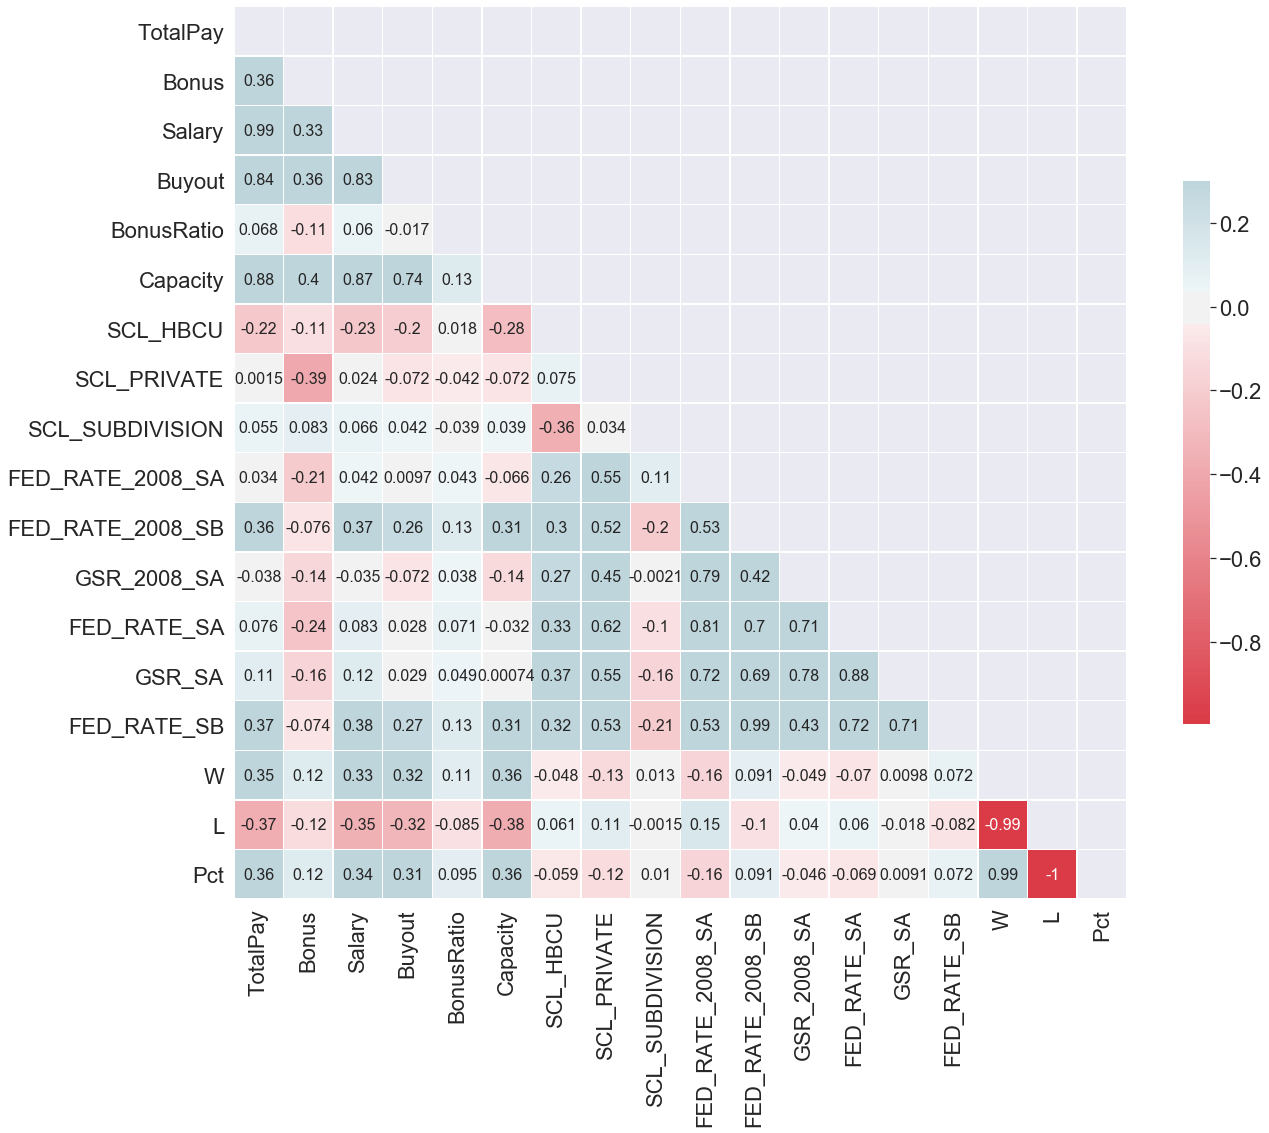

In [27]:
# correlation matrix
# get correlation between all variables
corr = labdf.corr()
# generate a mask for the upper triangle - gives a matrix of all 'False'
mask = np.zeros_like(corr, dtype = np.bool)
# change False to True
mask[np.triu_indices_from(mask)] = True

# make a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap = True)

# make the correlation matrix (heatmap) with the mask and aspect ratio
plt.figure(figsize = (20,20))
sns.set(font_scale = 2)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0, square = True, annot = True, \
            linewidths = 0.5, cbar_kws = {'shrink':0.5}, \
           annot_kws = {'size':16})
plt.show()

In [28]:
# get the conferences separated
aac = labdf[labdf['Conference'] == 'AAC']
acc = labdf[labdf['Conference'] == 'ACC']
big12 = labdf[labdf['Conference'] == 'Big 12']
big10 = labdf[labdf['Conference'] == 'Big Ten']
cusa = labdf[labdf['Conference'] == 'C-USA']
ind = labdf[labdf['Conference'] == 'Ind.']
mac = labdf[labdf['Conference'] == 'MAC']
mtw = labdf[labdf['Conference'] == 'Mt. West']
pac12 = labdf[labdf['Conference'] == 'Pac-12']
sec = labdf[labdf['Conference'] == 'SEC']
sunbelt = labdf[labdf['Conference'] == 'Sun Belt']

In [29]:
# salary by conference
data = [aac['Salary'], acc['Salary'], big12['Salary'], big10['Salary'], cusa['Salary'], ind['Salary'], mac['Salary'], mtw['Salary'], pac12['Salary'], sec['Salary'], sunbelt['Salary']]
ordered_conf = sorted(list(set(labdf['Conference'])))

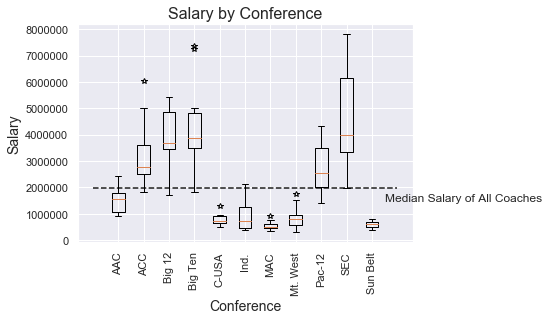

In [30]:
# box plot of salary by conference
sns.set(font_scale = 1)
fig, axis = plt.subplots()
axis.set_xlabel('Conference', size = 14)
axis.set_ylabel('Salary', size = 14)
axis.set_title('Salary by Conference', size = 16)
plt.boxplot(data, sym = '*', vert = 1, whis = 1.5)
plt.hlines(y = labdf['Salary'].median(), xmin = 0, xmax = 12, linestyle = 'dashed')
plt.text(x = 11.5, y = 1470000, text = 'Median Salary of All Coaches', s = 12)
axis.set_xticklabels(ordered_conf)
plt.xticks(rotation = 90)
plt.show()

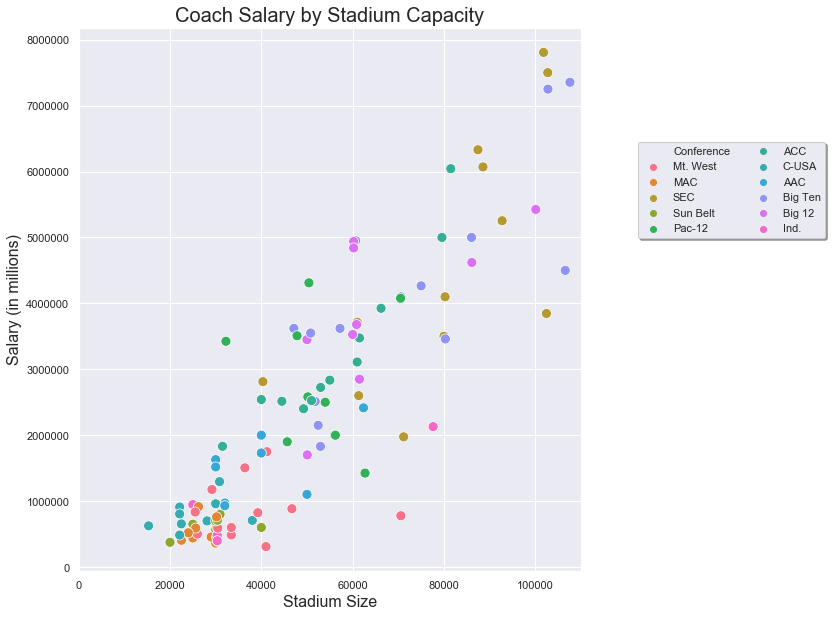

In [31]:
# salary by stadium size - hue = conference
fig, axis = plt.subplots(figsize = (15, 10))
sns.scatterplot(x = 'Capacity', y = 'Salary', hue = 'Conference', data = labdf, s = 100)
#sns.lmplot(x = 'Capacity', y = 'Salary', data = labdf)
axis.set_xlabel('Stadium Size', size = 16)
axis.set_ylabel('Salary (in millions)', size = 16)
axis.set_title('Coach Salary by Stadium Capacity', size = 20)
chartBox = axis.get_position()
axis.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
axis.legend(loc = 'upper center', bbox_to_anchor = (1.3, 0.8), shadow = True, ncol = 2)
plt.xlim(0, 110000)
plt.show()

<Figure size 432x288 with 0 Axes>

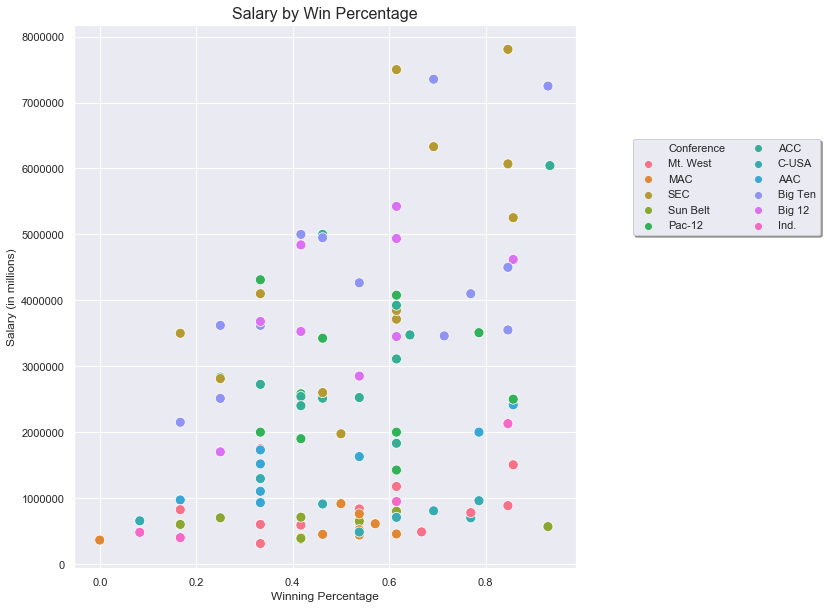

In [32]:
# salary by win percentage - hue = conference
plt.figure()
fig, axis = plt.subplots(figsize = (15, 10))
sns.scatterplot(x = 'Pct', y = 'Salary', hue = 'Conference', data = labdf, s = 100)
axis.set_xlabel('Winning Percentage')
axis.set_ylabel('Salary (in millions)')
axis.set_title('Salary by Win Percentage', size = 16)
chartBox = axis.get_position()
axis.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
axis.legend(loc = 'upper center', bbox_to_anchor = (1.3, 0.8), shadow = True, ncol = 2)
plt.show()

## Linear Regression

In [33]:
# How good is the model?
# get mean absolute error for the model
def mean_abs_error(series, ypred):
    abs_error = []
    for i in range(len(series)):
        # calculate absolute error
        error = np.abs(series[i] - ypred[i])
        abs_error.append(error)
    # calculate mean
    mae = round(np.mean(abs_error),2)
    print('On average, the model predicts a salary that is ${} off from the true salary.'\
          .format(mae))
# root mean squared error
def RMSE(series, ypred):
    temp_res = []
    n = len(series)
    for i in range(len(series)):
        # calculate square of residuals
        res_sq = (series[i] - ypred[i])**2
        temp_res.append(res_sq)
    rmse = np.sqrt(sum(temp_res)/n)
    print('On average, the Root Mean Squared Error is ${}.'.format(round(rmse, 2)))
    

### Model 1: Baseline 

In [34]:
# split data into test/train sets 2/3 - 1/3
np.random.seed(287) # reproducible results
# uniform distribution for splitting data
labdf['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(labdf))
labdf_train = labdf[labdf['runiform'] >= 0.33]
labdf_test = labdf[labdf['runiform'] < 0.33]
print(len(labdf_train) + len(labdf_test))

109


In [35]:
# reindex the train and test set for validity tests
labdf_train.index = range(len(labdf_train))
labdf_test.index = range(len(labdf_test))

In [36]:
### Linear Regression
# specify the model - dependent var = Salary
base_model = str('Salary ~ Conference + Capacity + Buyout + BonusRatio + SCL_HBCU + SCL_PRIVATE + \
             SCL_SUBDIVISION + FED_RATE_2008_SA + FED_RATE_2008_SB + \
             GSR_2008_SA  + FED_RATE_SA + GSR_SA + FED_RATE_SB + Pct')

# fit the model to the train set
base_model_fit = smf.ols(base_model, data = labdf_train).fit()

#summary of model fit to training set - output of regression
base_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     18.36
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           5.74e-18
Time:                        15:39:45   Log-Likelihood:                -1154.6
No. Observations:                  78   AIC:                             2357.
Df Residuals:                      54   BIC:                             2414.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4.411e+05   2.16e+06      0.204      0.839   -3.89e+06    4.78e+06
Conference[T.ACC]       4.236e+05   5.47e+05      0.774      0.442   -6.74e+05    1.52e+06
Conference[T.Big 12]    7.875e+05   5.74e+05      1.372      0.176   -3.63e+05    1.94e+06
Conference[T.Big Ten]   1.037e+06   6.07e+05      1.709      0.093    -1.8e+05    2.25e+06
Conference[T.C-USA]    -1.556e+05   5.55e+05     -0.280      0.780   -1.27e+06    9.58e+05
Conference[T.Ind.]     -4.711e+05   5.95e+05     -0.791      0.432   -1.66e+06    7.23e+05
Conference[T.MAC]      -5.021e+05   5.87e+05     -0.856      0.396   -1.68e+06    6.74e+05
Conference[T.Mt. West] -6.867e+05   5.23e+05     -1.313      0.195   -1.74e+06    3.62e+05
Conference[T.Pac-12]     4.98e+05   5.34e+05      0.933      0.355   -5.72e+05    1.57e+06
Conference[T.SEC]        4.75e+05   5.76e+05      0.825      0.413    -6.8e+05    1.63e+06
Conference[T.Sun Belt]  -6.31e+05   5.88e+05     -1.072      0.288   -1.81e+06    5.49e+05
Capacity                  27.7094      9.023      3.071      0.003       9.619      45.800
Buyout                     0.0669      0.013      5.221      0.000       0.041       0.093
BonusRatio             -6413.3782   8477.075     -0.757      0.453   -2.34e+04    1.06e+04
SCL_HBCU               -4.255e+05   6.22e+05     -0.684      0.497   -1.67e+06    8.21e+05
SCL_PRIVATE              3.47e+04   3.89e+05      0.089      0.929   -7.46e+05    8.16e+05
SCL_SUBDIVISION         9949.7258   2.49e+05      0.040      0.968   -4.88e+05    5.08e+05
FED_RATE_2008_SA        9604.1479   2.06e+04      0.465      0.644   -3.18e+04     5.1e+04
FED_RATE_2008_SB        7634.9834   6.13e+04      0.124      0.901   -1.15e+05    1.31e+05
GSR_2008_SA            -4.195e+04   2.74e+04     -1.531      0.132   -9.69e+04     1.3e+04
FED_RATE_SA            -7944.4175   3.47e+04     -0.229      0.820   -7.75e+04    6.16e+04
GSR_SA                  4.824e+04    3.3e+04      1.461      0.150    -1.8e+04    1.14e+05
FED_RATE_SB            -7665.4376   6.75e+04     -0.114      0.910   -1.43e+05    1.28e+05
Pct                     3.342e+05   5.35e+05      0.624      0.535   -7.39e+05    1.41e+06
==============================================================================
Omnibus:                        6.730   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.416
Skew:                           0.517   Prob(JB):                       0.0404
Kurtosis:                       3.952   Cond. No.                     3.55e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+08. This

In [37]:
# fit the model to the test set
base_pred_sal = base_model_fit.predict(labdf_test)
base_pred_sal.index = range(len(base_pred_sal))

# create a dataframe of actual and predicted
base_pred_act_df = pd.DataFrame({'act_sal':labdf_test['Salary'],'base_pred_sal':base_pred_sal})
#base_pred_act_df

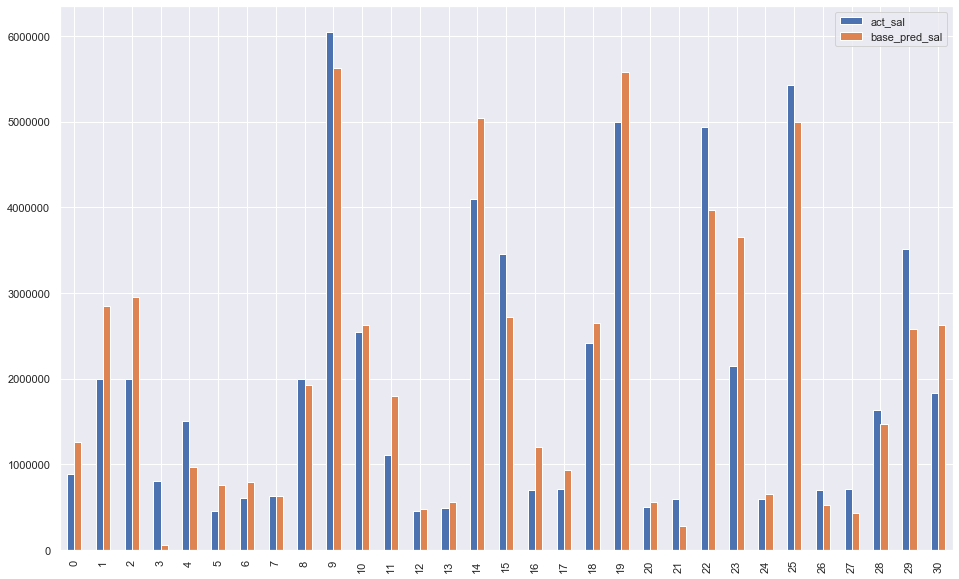

In [38]:
# plot predicted and actual
base_pred_act_df.plot(kind = 'bar', figsize = (16,10))

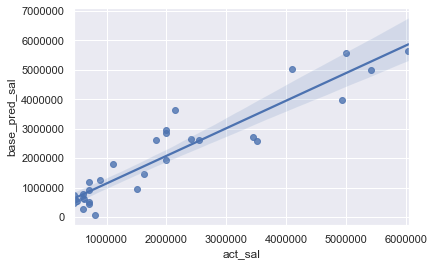

In [39]:
# regression plot on test set
sns.regplot(x = 'act_sal', y = 'base_pred_sal', data = base_pred_act_df)

In [40]:
# find mean absolute error on test set
base_mae_value = mean_abs_error(labdf_test['Salary'], base_pred_sal)
#base_mae_value

On average, the model predicts a salary that is $458669.57 off from the true salary.


In [41]:
# find root mean squared error
base_rmse_value = RMSE(labdf_test['Salary'], base_pred_sal)

On average, the Root Mean Squared Error is $586379.25.


## Model 2
Variable choices are from the correlation matrix above.

In [42]:
# specify the model - dependent var = Salary
model2 = str('Salary ~ Conference + Capacity + Buyout + SCL_HBCU + \
 FED_RATE_SB + GSR_SA + FED_RATE_SA + BonusRatio + Pct' )

# fit the model to the train set
model2_fit = smf.ols(model2, data = labdf_train).fit()

#summary of model fit to training set - output of regression
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     24.33
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           8.19e-21
Time:                        15:40:05   Log-Likelihood:                -1156.4
No. Observations:                  78   AIC:                             2351.
Df Residuals:                      59   BIC:                             2396.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -7.893e+05   1.56e+06     -0.506      0.615   -3.91e+06    2.33e+06
Conference[T.ACC]       2.194e+05   4.95e+05      0.443      0.659   -7.72e+05    1.21e+06
Conference[T.Big 12]    6.503e+05   5.35e+05      1.215      0.229   -4.21e+05    1.72e+06
Conference[T.Big Ten]   7.803e+05   5.47e+05      1.425      0.159   -3.15e+05    1.88e+06
Conference[T.C-USA]    -2.616e+05   5.34e+05     -0.490      0.626   -1.33e+06    8.08e+05
Conference[T.Ind.]     -5.939e+05   5.72e+05     -1.038      0.304   -1.74e+06    5.51e+05
Conference[T.MAC]      -5.496e+05   5.42e+05     -1.014      0.315   -1.63e+06    5.35e+05
Conference[T.Mt. West]   -7.7e+05   4.96e+05     -1.554      0.126   -1.76e+06    2.21e+05
Conference[T.Pac-12]    3.543e+05   5.03e+05      0.704      0.484   -6.52e+05    1.36e+06
Conference[T.SEC]       3.381e+05   5.48e+05      0.617      0.540   -7.59e+05    1.44e+06
Conference[T.Sun Belt] -5.633e+05   5.53e+05     -1.018      0.313   -1.67e+06    5.44e+05
Capacity                  31.0030      8.487      3.653      0.001      14.021      47.985
Buyout                     0.0668      0.012      5.408      0.000       0.042       0.092
SCL_HBCU               -3.801e+05   5.52e+05     -0.689      0.494   -1.48e+06    7.24e+05
FED_RATE_SB              697.0309   1.23e+04      0.057      0.955    -2.4e+04    2.54e+04
GSR_SA                  2.113e+04   2.72e+04      0.777      0.440   -3.33e+04    7.55e+04
FED_RATE_SA            -1838.1152   2.63e+04     -0.070      0.945   -5.45e+04    5.08e+04
BonusRatio             -6439.3849   8226.897     -0.783      0.437   -2.29e+04       1e+04
Pct                     3.411e+05   5.12e+05      0.666      0.508   -6.84e+05    1.37e+06
==============================================================================
Omnibus:                        6.584   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.165
Skew:                           0.519   Prob(JB):                       0.0459
Kurtosis:                       3.905   Cond. No.                     2.64e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# fit the model to the test set
pred_sal2 = model2_fit.predict(labdf_test)
pred_sal2.index = range(len(pred_sal2))
pred_act_2_df = pd.DataFrame({'act_sal':labdf_test['Salary'], 'pred_sal':pred_sal2})
#pred_act_2_df

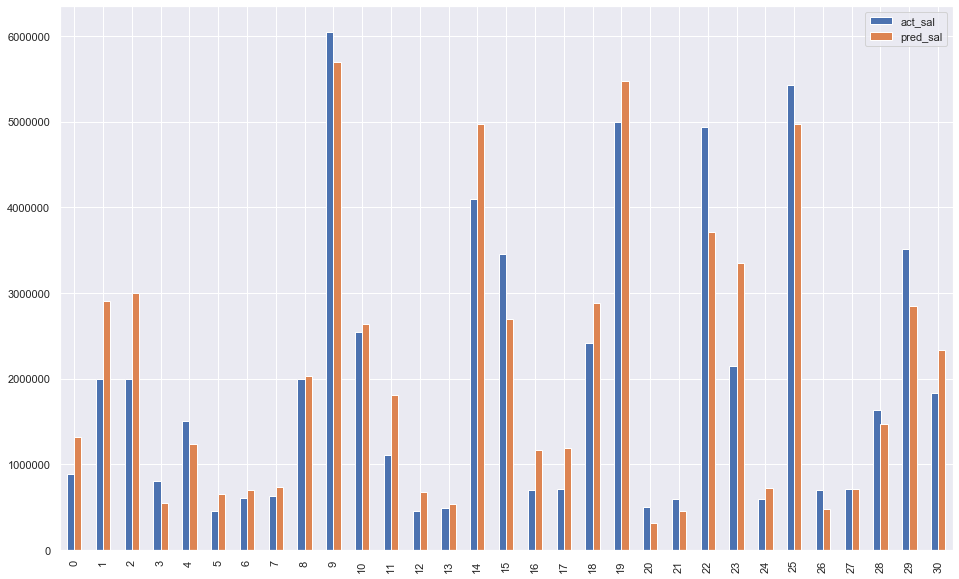

In [44]:
pred_act_2_df.plot(kind = 'bar', figsize = (16, 10))

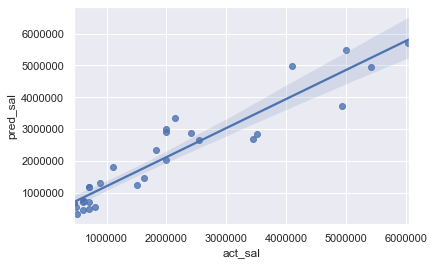

In [45]:
# regression plot on test set
sns.regplot(x = 'act_sal', y = 'pred_sal', data = pred_act_2_df)

In [46]:
# find mean absolute error on test set
mae_value2 = mean_abs_error(labdf_test['Salary'], pred_sal2)
mae_value2

On average, the model predicts a salary that is $423177.23 off from the true salary.


In [47]:
# find root mean squared error
rmse_value_2 = RMSE(labdf_test['Salary'], pred_sal2)

On average, the Root Mean Squared Error is $541515.69.


## Model 3 - (Model 1 in Report) - BEST MODEL USED FOR PREDICTION
Variable choices are made from p-values in Model 2

In [48]:
# specify the model - dependent var = Salary
model3 = str('Salary ~ Conference + Capacity + Buyout + FED_RATE_SB + Pct + SCL_HBCU')

# fit the model to the train set
model3_fit = smf.ols(model3, data = labdf_train).fit()

#summary of model fit to training set - output of regression
model3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     29.62
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           1.29e-22
Time:                        15:42:59   Log-Likelihood:                -1157.6
No. Observations:                  78   AIC:                             2347.
Df Residuals:                      62   BIC:                             2385.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4.401e+05   1.02e+06      0.431      0.668    -1.6e+06    2.48e+06
Conference[T.ACC]       3.072e+05   4.84e+05      0.635      0.528    -6.6e+05    1.27e+06
Conference[T.Big 12]    7.358e+05   5.22e+05      1.409      0.164   -3.08e+05    1.78e+06
Conference[T.Big Ten]   8.678e+05   5.04e+05      1.722      0.090    -1.4e+05    1.88e+06
Conference[T.C-USA]    -2.231e+05   5.22e+05     -0.427      0.671   -1.27e+06    8.21e+05
Conference[T.Ind.]     -5.194e+05    5.4e+05     -0.962      0.340    -1.6e+06     5.6e+05
Conference[T.MAC]      -4.841e+05   4.93e+05     -0.982      0.330   -1.47e+06    5.01e+05
Conference[T.Mt. West] -7.384e+05   4.85e+05     -1.523      0.133   -1.71e+06    2.31e+05
Conference[T.Pac-12]    3.858e+05   4.93e+05      0.782      0.437      -6e+05    1.37e+06
Conference[T.SEC]       4.224e+05   5.37e+05      0.787      0.434   -6.51e+05     1.5e+06
Conference[T.Sun Belt] -5.498e+05   5.46e+05     -1.007      0.318   -1.64e+06    5.42e+05
Capacity                  28.2634      7.913      3.572      0.001      12.447      44.080
Buyout                     0.0677      0.012      5.700      0.000       0.044       0.091
FED_RATE_SB             7455.4683   7689.177      0.970      0.336   -7914.978    2.28e+04
Pct                     3.201e+05   5.03e+05      0.636      0.527   -6.86e+05    1.33e+06
SCL_HBCU               -3.734e+05   5.28e+05     -0.707      0.482   -1.43e+06    6.82e+05
==============================================================================
Omnibus:                        7.293   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.167
Skew:                           0.539   Prob(JB):                       0.0278
Kurtosis:                       4.020   Cond. No.                     2.27e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# fit the model to the test set
pred_sal3 = model3_fit.predict(labdf_test)
pred_sal3.index = range(len(pred_sal3))
pred_act_3_df = pd.DataFrame({'act_sal':labdf_test['Salary'], 'pred_sal':pred_sal3})
#pred_act_3_df

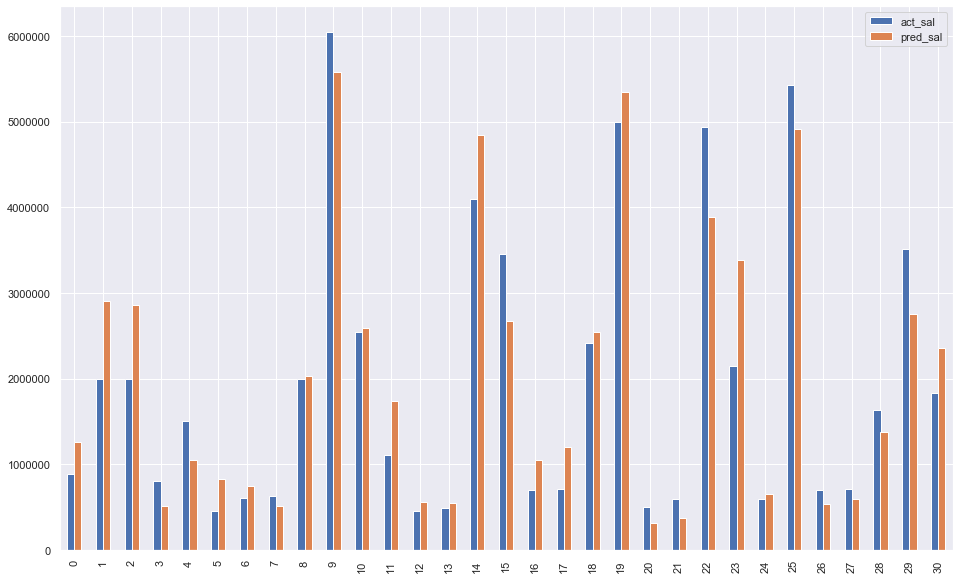

In [50]:
pred_act_3_df.plot(kind = 'bar', figsize = (16, 10))

Text(0.5, 1.0, 'Model 1: Actual and Predicted Salary')

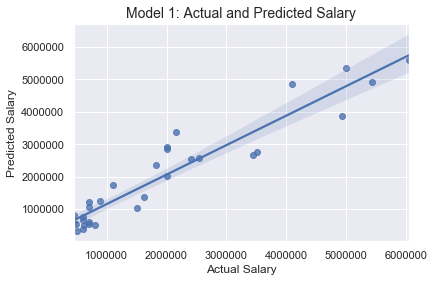

In [51]:
# regression plot on test set
sns.regplot(x = 'act_sal', y = 'pred_sal', data = pred_act_3_df)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Model 1: Actual and Predicted Salary', size = 14)

In [52]:
# find mean absolute error on test set
mae_value3 = mean_abs_error(labdf_test['Salary'], pred_sal3)

On average, the model predicts a salary that is $411088.69 off from the true salary.


In [53]:
rmse_value3 = RMSE(labdf_test['Salary'], pred_sal3)

On average, the Root Mean Squared Error is $519774.39.


## Model 4: (Model 2 in Report) No outliers (Nick Saban of Alabama)

In [54]:
# data frame is no_al

# split data into test/train sets 2/3 - 1/3
np.random.seed(287) # reproducible results
# uniform distribution for splitting data
no_al['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(no_al))
no_al_train = no_al[no_al['runiform'] >= 0.33]
no_al_test = no_al[no_al['runiform'] < 0.33]
print(len(no_al_train) + len(no_al_test))

108


In [55]:
# reindex the train and test sets
no_al_train.index = range(len(no_al_train))
no_al_test.index = range(len(no_al_test))

In [56]:
# specify the model - dependent var = Salary
no_al_model = str('Salary ~ Conference + Capacity + Buyout + FED_RATE_SB')

# fit the model to the train set
no_al_model_fit = smf.ols(no_al_model, data = no_al_train).fit()

#summary of model fit to training set - output of regression
no_al_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     48.99
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           7.19e-28
Time:                        15:43:27   Log-Likelihood:                -1118.2
No. Observations:                  77   AIC:                             2264.
Df Residuals:                      63   BIC:                             2297.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -5.06e+05   4.92e+05     -1.028      0.308   -1.49e+06    4.77e+05
Conference[T.ACC]       3.972e+05   3.75e+05      1.058      0.294   -3.53e+05    1.15e+06
Conference[T.Big 12]    1.386e+06   3.92e+05      3.532      0.001    6.02e+05    2.17e+06
Conference[T.Big Ten]   6.769e+05   3.91e+05      1.732      0.088   -1.04e+05    1.46e+06
Conference[T.C-USA]    -7.428e+04   3.89e+05     -0.191      0.849   -8.51e+05    7.02e+05
Conference[T.Ind.]     -2.642e+05   4.16e+05     -0.635      0.527    -1.1e+06    5.67e+05
Conference[T.MAC]      -3.107e+05   3.75e+05     -0.828      0.411   -1.06e+06    4.39e+05
Conference[T.Mt. West] -4.194e+05    3.9e+05     -1.075      0.287    -1.2e+06     3.6e+05
Conference[T.Pac-12]    8.674e+05   3.79e+05      2.291      0.025    1.11e+05    1.62e+06
Conference[T.SEC]       1.685e+05   4.15e+05      0.406      0.686    -6.6e+05    9.97e+05
Conference[T.Sun Belt] -2.095e+05   3.85e+05     -0.544      0.588   -9.79e+05     5.6e+05
Capacity                  23.6624      5.300      4.465      0.000      13.071      34.254
Buyout                     0.0879      0.013      6.544      0.000       0.061       0.115
FED_RATE_SB              1.14e+04   4877.212      2.337      0.023    1650.259    2.11e+04
==============================================================================
Omnibus:                        3.052   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.950
Skew:                           0.017   Prob(JB):                        0.229
Kurtosis:                       3.958   Cond. No.                     1.88e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
# fit the model to the test set
no_al_pred_sal = no_al_model_fit.predict(no_al_test)
no_al_pred_sal.index = range(len(no_al_pred_sal))
pred_act_noal_df = pd.DataFrame({'pred_sal':no_al_pred_sal, 'act_sal':no_al_test['Salary']})
#pred_act_noal_df

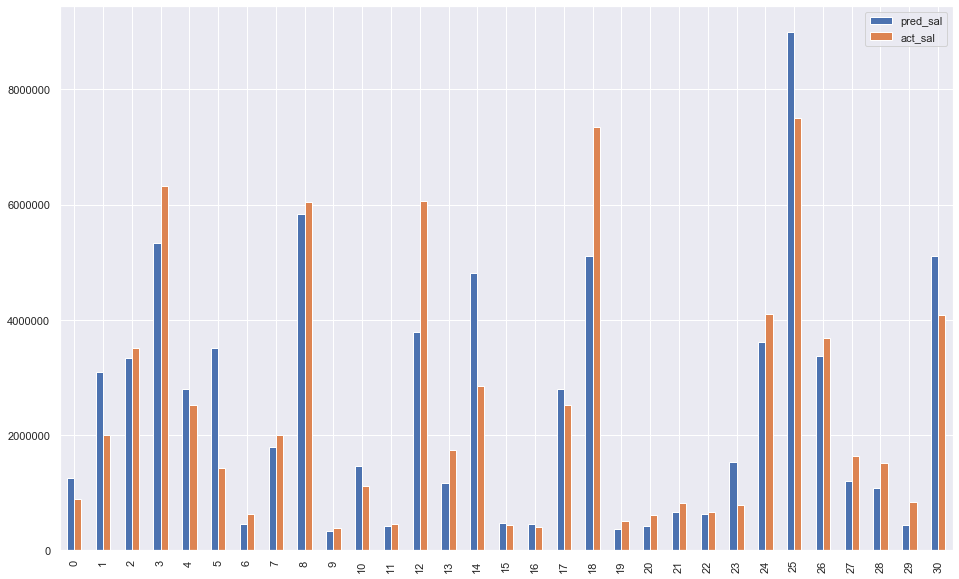

In [58]:
# plot actual and predicted salaries
pred_act_noal_df.plot(kind = 'bar', figsize = (16, 10))

In [59]:
# which schools are so far off?
row_list = [12, 18]
no_al_test.loc[row_list]

,School,Conference,Coach,TotalPay,Bonus,Salary,Buyout,BonusRatio,Capacity,SCL_NAME,...,FED_RATE_2008_SA,FED_RATE_2008_SB,GSR_2008_SA,FED_RATE_SA,GSR_SA,FED_RATE_SB,W,L,Pct,runiform
12,Florida,SEC,Dan Mullen,6070000.0,925000.0,6070000.0,12000000.0,0.000000,88548.0,University of Florida,...,63.0,88.0,80.0,59.0,81.0,86.0,11.0,2.0,0.846,0.186499
18,Michigan,Big Ten,Jim Harbaugh,7504000.0,1325000.0,7354000.0,17111110.0,0.113208,107601.0,Michigan State University,...,72.0,79.0,88.0,70.0,87.0,78.0,9.0,4.0,0.692,0.096536


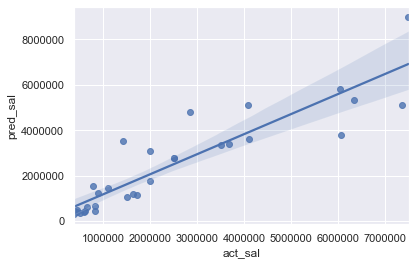

In [60]:
# regression plot on test set
sns.regplot(x = 'act_sal', y = 'pred_sal', data = pred_act_noal_df)

In [61]:
# mean absolute error
no_al_mae = mean_abs_error(no_al_test['Salary'], no_al_pred_sal)

On average, the model predicts a salary that is $622436.82 off from the true salary.


In [62]:
# root mean squared error
no_al_rmse = RMSE(no_al_test['Salary'], no_al_pred_sal)

On average, the Root Mean Squared Error is $921017.29.


In [64]:
# percent increase in Mean Absolute Error from previous model
round((634226-404618)/404618*100,2)

56.75

## Model 5: (Model 3) in the Report - Normalized values with outliers

In [65]:
# How good is the model?

# get mean absolute error for the normalized model
def norm_mean_abs_error(series_norm, series_val, ypred):
    abs_error = []
    for i in range(len(series_norm)):
        # calculate absolute error
        error = np.abs(series_norm[i] - ypred[i])
        abs_error.append(error)
    # calculate mean
    mae = round(np.mean(abs_error),2)
    sal = round((series_val.mean() + mae*series_val.std()),2)
    print('On average, the model predicts a salary that is {} standard deviations off from the true salary.\
          \nOn average, this is ${} off from actual salary.'.format(mae, sal))

# root mean squared error
def norm_RMSE(series_norm, series_val, ypred):
    temp_res = []
    n = len(series_norm)
    for i in range(len(series_norm)):
        # calculate square of residuals
        res_sq = (series_norm[i] - ypred[i])**2
        temp_res.append(res_sq)
    rmse = round(np.sqrt(sum(temp_res)/n),2)
    sal = round((series_val.mean() + rmse*series_val.std()),2)
    print('On average, the Root Mean Squared error is {} stadard deviations from the true salary.\
          \nOn average, this is ${} .'.format(rmse, sal))
    

In [66]:
# df is labdf_norm

# split data into test/train sets 2/3 - 1/3
np.random.seed(287) # reproducible results
# uniform distribution for splitting data
labdf_norm['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(labdf_norm))
labdf_norm_train = labdf_norm[labdf_norm['runiform'] >= 0.33]
labdf_norm_test = labdf_norm[labdf_norm['runiform'] < 0.33]
print(len(labdf_norm_train) + len(labdf_norm_test))

109


In [67]:
# reindex test and train sets
labdf_norm_train.index = range(len(labdf_norm_train))
labdf_norm_test.index = range(len(labdf_norm_test))

In [68]:
# specify the model - dependent var = Salary
norm_model = str('Salary ~ Conference + Capacity + Buyout + FED_RATE_SB')

# fit the model to the train set
norm_model_fit = smf.ols(norm_model, data = labdf_norm_train).fit()

#summary of model fit to training set - output of regression
norm_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     34.72
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           5.65e-24
Time:                        15:44:23   Log-Likelihood:                -31.410
No. Observations:                  78   AIC:                             90.82
Df Residuals:                      64   BIC:                             123.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0460      0.208     -0.222      0.825      -0.461       0.369
Conference[T.ACC]          0.1830      0.254      0.720      0.474      -0.324       0.690
Conference[T.Big 12]       0.3702      0.275      1.347      0.183      -0.179       0.919
Conference[T.Big Ten]      0.4637      0.266      1.743      0.086      -0.068       0.995
Conference[T.C-USA]       -0.0958      0.266     -0.360      0.720      -0.627       0.435
Conference[T.Ind.]        -0.2648      0.284     -0.933      0.355      -0.832       0.302
Conference[T.MAC]         -0.2406      0.255     -0.944      0.349      -0.750       0.268
Conference[T.Mt. West]    -0.3892      0.253     -1.539      0.129      -0.895       0.116
Conference[T.Pac-12]       0.2246      0.259      0.867      0.389      -0.293       0.742
Conference[T.SEC]          0.2392      0.280      0.855      0.396      -0.320       0.798
Conference[T.Sun Belt]    -0.2542      0.273     -0.930      0.356      -0.800       0.292
Capacity                   0.3945      0.085      4.665      0.000       0.226       0.563
Buyout                     0.3705      0.065      5.743      0.000       0.242       0.499
FED_RATE_SB                0.0386      0.054      0.713      0.478      -0.069       0.147
==============================================================================
Omnibus:                        8.541   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.800
Skew:                           0.600   Prob(JB):                       0.0123
Kurtosis:                       4.126   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# fit the model to the test set
norm_pred_sal = norm_model_fit.predict(labdf_norm_test)
norm_pred_sal.index = range(len(norm_pred_sal))
pred_act_norm_df = pd.DataFrame({'pred_sal':norm_pred_sal, 'act_sal':labdf_norm_test['Salary']})
#pred_act_norm_df

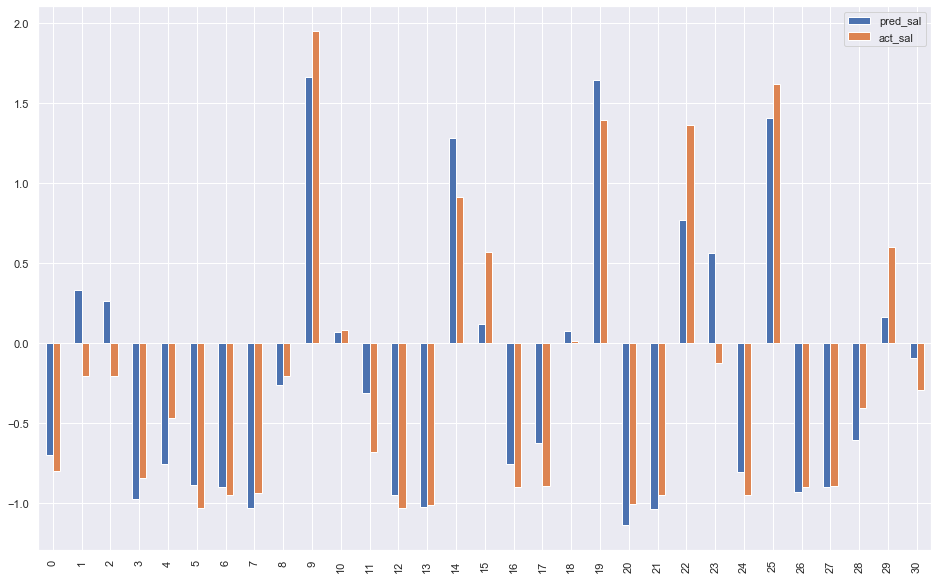

In [70]:
# plot actual and predicted values
pred_act_norm_df.plot(kind = 'bar', figsize = (16, 10))

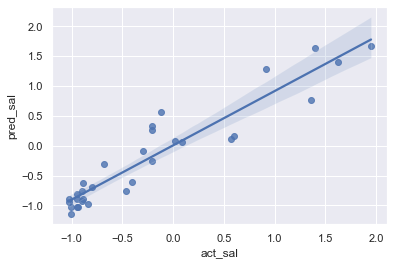

In [71]:
# regression plot on test set
sns.regplot(x = 'act_sal', y = 'pred_sal', data = pred_act_norm_df)

In [72]:
# mean absolute error
norm_mean_abs_error(labdf_norm_test['Salary'], labdf_test['Salary'], norm_pred_sal)

On average, the model predicts a salary that is 0.22 standard deviations off from the true salary.          
On average, this is $2315623.96 off from actual salary.


In [73]:
norm_RMSE(labdf_norm_test['Salary'], labdf_test['Salary'], norm_pred_sal)

On average, the Root Mean Squared error is 0.29 stadard deviations from the true salary.          
On average, this is $2431772.14 .


## Model 6: Normalized data without outliers (No Nick Saban of Alabama)

In [74]:
# drop the outlier
#labdf_norm.head()
norm_noal = labdf_norm.drop(2)
norm_noal.index = range(len(norm_noal))
norm_noal.head()

,School,Conference,Coach,TotalPay,Bonus,Salary,Buyout,BonusRatio,Capacity,SCL_NAME,...,FED_RATE_2008_SA,FED_RATE_2008_SB,GSR_2008_SA,FED_RATE_SA,GSR_SA,FED_RATE_SB,W,L,Pct,runiform
0,Air Force,Mt. West,Troy Calhoun,-0.826480,-0.804569,-0.797859,-0.685315,-0.108744,-0.145183,United States Air Force Academy,...,-0.347910,1.310752,0.541251,-0.286641,0.914466,1.320212,1.387344,-1.630472,1.531919,0.144485
1,Akron,MAC,Terry Bowden,-1.068256,-0.837331,-1.076053,-0.753043,-0.085519,-0.858921,University of Akron Main Campus,...,0.157719,-1.226169,-0.705151,-0.056907,-0.439838,-1.277094,-2.197624,2.436380,-2.427618,0.710753
2,Appalachian State,Sun Belt,Scott Satterfield,-0.914747,-0.733087,-0.966905,-0.610867,-0.057373,-0.858921,Appalachian State University,...,-0.145658,0.444486,-0.566662,0.057961,0.101883,0.330762,2.039156,-2.037157,1.920384,0.771227
3,Arizona,Pac-12,Kevin Sumlin,-0.255942,1.843237,-0.204200,0.146376,-0.108744,0.254061,University of Arizona,...,-0.651288,-0.174275,-0.289684,-0.631243,-0.439838,-0.040281,-0.893999,0.809639,-0.869077,0.221419
4,Arizona State,Pac-12,Herm Edwards,-0.255942,3.310104,-0.204200,-0.030710,-0.108744,0.262741,Arizona State University-Tempe,...,-0.145658,0.011353,0.402762,-0.056907,0.372744,-0.163963,0.409625,-0.410416,0.450769,0.018113


In [75]:
# split data into test/train sets 2/3 - 1/3
np.random.seed(287) # reproducible results
# uniform distribution for splitting data
norm_noal['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(norm_noal))
norm_noal_train = norm_noal[norm_noal['runiform'] >= 0.33]
norm_noal_test = norm_noal[norm_noal['runiform'] < 0.33]
print(len(norm_noal_train) + len(norm_noal_test))

108


In [76]:
# reindex the test and train sets
norm_noal_train.index = range(len(norm_noal_train))
norm_noal_test.index = range(len(norm_noal_test))

In [77]:
# specify the model - dependent var = Salary
norm_noal_model = str('Salary ~ Conference + Capacity + Buyout + FED_RATE_SB')

# fit the model to the train set
norm_noal_model_fit = smf.ols(norm_noal_model, data = norm_noal_train).fit()

#summary of model fit to training set - output of regression
norm_noal_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     48.99
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           7.19e-28
Time:                        15:44:40   Log-Likelihood:                -5.8995
No. Observations:                  77   AIC:                             39.80
Df Residuals:                      63   BIC:                             72.61
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1363      0.170     -0.800      0.427      -0.477       0.204
Conference[T.ACC]          0.2115      0.200      1.058      0.294      -0.188       0.611
Conference[T.Big 12]       0.7378      0.209      3.532      0.001       0.320       1.155
Conference[T.Big Ten]      0.3604      0.208      1.732      0.088      -0.055       0.776
Conference[T.C-USA]       -0.0396      0.207     -0.191      0.849      -0.453       0.374
Conference[T.Ind.]        -0.1407      0.221     -0.635      0.527      -0.583       0.302
Conference[T.MAC]         -0.1654      0.200     -0.828      0.411      -0.565       0.234
Conference[T.Mt. West]    -0.2233      0.208     -1.075      0.287      -0.639       0.192
Conference[T.Pac-12]       0.4618      0.202      2.291      0.025       0.059       0.865
Conference[T.SEC]          0.0897      0.221      0.406      0.686      -0.351       0.531
Conference[T.Sun Belt]    -0.1115      0.205     -0.544      0.588      -0.521       0.298
Capacity                   0.2946      0.066      4.465      0.000       0.163       0.427
Buyout                     0.4846      0.074      6.544      0.000       0.337       0.633
FED_RATE_SB                0.0981      0.042      2.337      0.023       0.014       0.182
==============================================================================
Omnibus:                        3.052   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.950
Skew:                           0.017   Prob(JB):                        0.229
Kurtosis:                       3.958   Cond. No.                         21.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
# fit the model to the test set
norm_noal_pred_sal = norm_model_fit.predict(norm_noal_test)
norm_noal_pred_sal.index = range(len(norm_noal_pred_sal))
pred_act_norm_noal_df = pd.DataFrame({'pred_sal':norm_noal_pred_sal, 'act_sal':norm_noal_test['Salary']})
#pred_act_norm_noal_df

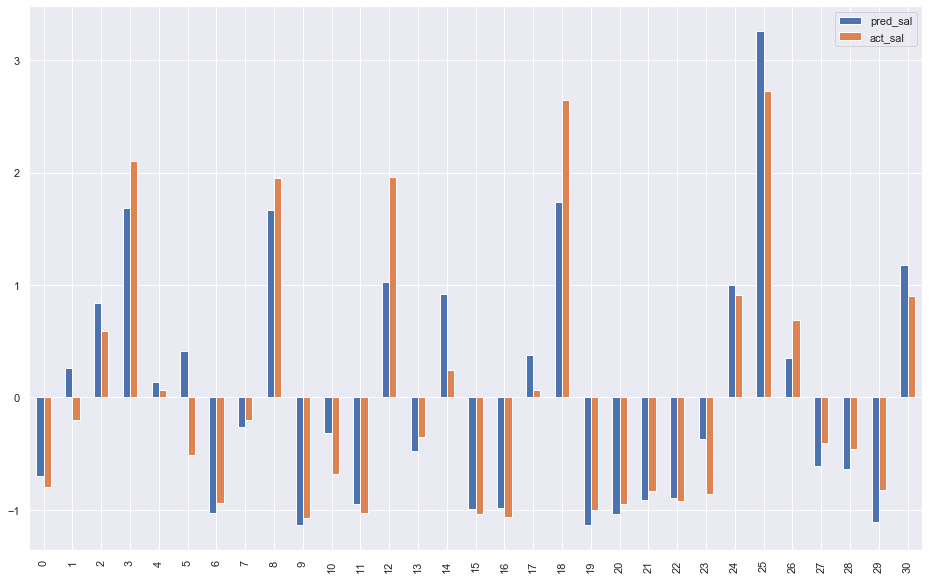

In [79]:
# plot actual salary and predicted salary
pred_act_norm_noal_df.plot(kind = 'bar', figsize = (16, 10))

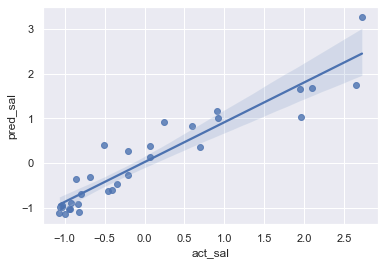

In [81]:
# regression plot on test set
sns.regplot(x = 'act_sal', y = 'pred_sal', data = pred_act_norm_noal_df)

In [82]:
# mean absolute error
norm_mean_abs_error(norm_noal_test['Salary'], no_al_test['Salary'], norm_noal_pred_sal)

On average, the model predicts a salary that is 0.29 standard deviations off from the true salary.          
On average, this is $3066283.69 off from actual salary.


In [83]:
norm_RMSE(norm_noal_test['Salary'], no_al_test['Salary'],norm_noal_pred_sal)

On average, the Root Mean Squared error is 0.39 stadard deviations from the true salary.          
On average, this is $3286103.43 .


## Predictions - Used Model 3 in the report
Model 6 has the highest adjusted R squared of all models. 
Model 3 has the lowest Mean Absolute Error and Root Mean Squares Error of all unnormalized models.

In [84]:
predict_df = labdf.loc[labdf['School'] == 'Syracuse']
norm_predict_df = labdf_norm.loc[labdf_norm['School'] == 'Syracuse']

#predict_df
#norm_predict_df

## How much should Dino Babers earn?

In [85]:
pred_sal = float(round(model3_fit.predict(predict_df),2))
print("The predicted salary for Syracuse's head coach is ${}.".format(pred_sal))


The predicted salary for Syracuse's head coach is $2750888.85.


### What if Syracuse was still in Big East (AAC)?

In [86]:
# What if Syracuse was still in Big East, AAC?

# change conference to AAC
norm_predict_df['Conference'] = 'AAC'
#norm_predict_df

predict_df['Conference'] = 'AAC'
#predict_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [87]:
# use model 6 norm_noal_model to predict normalized data
pred_z_sal = norm_model_fit.predict(norm_predict_df)
# get actual salary: x = mean + z * stdev
pred_sal = float(round((labdf['Salary'].mean() + pred_z_sal*labdf['Salary'].std()),2))
print("The predicted salary for Syracuse's head coach is ${}.".format(pred_sal))
print('The actual salary is ${}.'.format(round(labdf['Salary'][85],2)))

The predicted salary for Syracuse's head coach is $2403307.37.
The actual salary is $2401206.0.


In [88]:
# use model 3 to predict unnormalized data
pred_sal = float(round(model3_fit.predict(predict_df),2))
print("The predicted salary for Syracuse's head coach is ${}.".format(pred_sal))
print('The actual salary is ${}.'.format(round(labdf['Salary'][85],2)))


The predicted salary for Syracuse's head coach is $2443645.35.
The actual salary is $2401206.0.


### What if Syracuse went to the Big 10?

In [89]:
predict_df['Conference'] = 'Big Ten'
norm_predict_df['Conference'] = 'Big Ten'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
# use model 6 norm_noal_model to predict normalized data
pred_z_sal = norm_model_fit.predict(norm_predict_df)
# get actual salary: x = mean + z * stdev
pred_sal = float(round((labdf['Salary'].mean() + pred_z_sal*labdf['Salary'].std()),2))
print("The predicted salary for Syracuse's head coach is ${}.".format(pred_sal))
print('The actual salary is ${}.'.format(round(labdf['Salary'][85],2)))

The predicted salary for Syracuse's head coach is $3274299.96.
The actual salary is $2401206.0.


In [91]:
# use model 3 to predict unnormalized data
pred_sal = float(round(model3_fit.predict(predict_df),2))
print("The predicted salary for Syracuse's head coach is ${}.".format(pred_sal))
print('The actual salary is ${}.'.format(round(labdf['Salary'][85],2)))


The predicted salary for Syracuse's head coach is $3311432.97.
The actual salary is $2401206.0.
